# Pointcloud version including PyTorch Geometric
This notebook tests the functionality of the second implemenation of the GCN. Here we implement both a pointcloud version and a mesh version seperately on every component level. This version gets the help from PyTorch Geometric, which should speedup the application and make programming easier. The Mesh version is there to justify this version as a reimplementation of the paper and the pointcloud version is the purpose of the research.
## Structure Notebook
The following secions will be here to justify the implementation of the second verion.
- Pre-processing data
    - Create artificial noise (Store Ground Truth)
    - Patch selection
    - Patch alignment (Classify Patch)
    - Converting patch to graph
    - Storing graph in file
- Training GCN
    - Defining input and output for network
    - Create GCN architecture
        - Must be modifiable! (Create hyperparameters)
    - Selecting and loading data
        - Select based on object, noise level and patch class
        - Select based on training, validation and test group
    - Train network
        - Create log structure to view training process.
        - Be able to start and stop training.
        - Save and log training progress, such that is can be fully recreated (Per training session log: Architecture, Model weights, Hyperparameter settings, Epochs trained, Trainingset per Epoch, )
        - LOG EVERYTHING
- Post-processing data
    - Create pipeline for pre-processing data and input the network without storing data in files.
    - Reverse patch alignment of network output.
    - Create Vertex updating based on normals.
    - Create normal refinement (bilateral filter).
# Settings

In [1]:
from Pointcloud.Modules.GraphBuilder import GraphBuilder
from Pointcloud.Modules.Model import Patch2NormalModel
from Pointcloud.Modules.Noise import Noise
from Pointcloud.Modules.Object import FilePointcloud, FileMesh, Pointcloud
from Pointcloud.Modules.Preprocessor import Preprocessor
from Pointcloud.Modules.FileDataset import FileDataset, NoiseLevels
from Pointcloud.Modules.Visualize import visualize_coloring, plot_2d

from copy import deepcopy
from deltaconv.geometry import estimate_basis
from igl import barycenter as igl_barycenter,\
    bounding_box_diagonal as igl_bounding_box_diagonal,\
    triangle_triangle_adjacency as igl_triangle_triangle_adjacency,\
    avg_edge_length as igl_avg_edge_length
from itertools import zip_longest
from meshplot import plot as mp_plot
from gravomg.util import neighbors_from_stiffness
import numpy as np
from numpy import random as np_random
from pathlib import Path
import matplotlib.pyplot as plt
from robust_laplacian import point_cloud_laplacian
from scipy.spatial import Delaunay,\
    KDTree
from sklearn.preprocessing import normalize as sklearn_preprocessing_normalize
from timeit import timeit
import torch_geometric as tg
from torch_cluster import knn_graph
import torch
from tqdm import tqdm

EXAMPLE_OBJ_FILE = "common-3d-test-models-master/stanford-bunny.obj"
# EXAMPLE_OBJ_FILE = "common-3d-test-models-master/fandisk.obj"

c:\Users\ruben\miniconda3\envs\PCDenoiser\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\ruben\miniconda3\envs\PCDenoiser\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


# Pre-processing
In this section we show that all pre-processing steps are taken in the correct fashion.
## Loading (and calculating) object data
In this section we show that loading the example mesh can be done and that the object can be viewed as pointcloud and as mesh (with normals per face and normals per vertex)

In [2]:
pointcloud = FilePointcloud(EXAMPLE_OBJ_FILE)
mesh = FileMesh(EXAMPLE_OBJ_FILE)

In [3]:
normal_display_length = igl_bounding_box_diagonal(pointcloud.v) / 100
starts = pointcloud.v
ends = starts + pointcloud.vn * normal_display_length
pplot = mp_plot(starts, shading={"point_size": 0.005})
pplot.add_lines(starts, ends)
barycenters = igl_barycenter(mesh.v, mesh.f)
mplot = mp_plot(mesh.v, mesh.f)
_ = mplot.add_lines(barycenters, barycenters + mesh.fn * normal_display_length)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

## Defining neighbourhoods for pointclouds
There are 2 methods implemented for neighbourhood definitions. Creating a KNN graph on the pointcloud and creating a robust laplacian. The second method is a lot slower then the first method, but the second method probably represents a better neighbourhood definition.

In [4]:
knn_pointcloud_graph = pointcloud.toGraph(0)
robust_pointcloud_graph = pointcloud.toGraph(1)
knn_edges = knn_pointcloud_graph.edge_index
robust_edges = robust_pointcloud_graph.edge_index

In [7]:
graph = GraphBuilder.pointcloudToGraph(Pointcloud(torch.from_numpy(pointcloud.v)))
GraphBuilder.generateNormalsDeltaconv(graph)
preprocessor = Preprocessor(graph)
neighbours = preprocessor.selector.getVectorizedKRing(1, graph.edge_index)
print(neighbours)

Calculating k-ring in batches.: 100%|██████████| 1/1 [00:15<00:00, 15.43s/it]


SlicedTorchData(data=tensor([    0,   469,  1619,  ..., 35535, 35768, 35946]), slices=tensor([     0,      7,     15,  ..., 258954, 258965, 258973]))


In [8]:
example_neighbours = neighbours[1].nonzero().squeeze()
others = example_neighbours[1:]
pos = pointcloud.v[example_neighbours]
diff = (pos - pos[0])[1:]
outer = diff[..., None] * diff[:, None]
T = outer.sum(axis=0)
eigh = np.linalg.eigh(T)
small = np.argmin(eigh[0])
normal = eigh[1].T[small]

In the image below, the black edges are created by the knn neighbourhood for k=12 and the blue edges are created by the robust laplacian method. 3 visualizations are shown to illustrate the difference of the assignment of the edges.

In [9]:
distance = (igl_bounding_box_diagonal(pointcloud.v)**2/3)**0.5
num_v = pointcloud.v.shape[0]
vertices = np.r_[pointcloud.v, pointcloud.v + distance*np.array([1, 0, 0]), pointcloud.v + distance*np.array([2, 0, 0])]
plot = mp_plot(vertices, shading={"point_color": "green", "point_size": 0.00000001})
plot.add_lines(vertices[knn_edges[0]], vertices[knn_edges[1]], shading={"line_color": "black", "line_width": 0.00001})
plot.add_lines(vertices[robust_edges[0]+num_v], vertices[robust_edges[1]+num_v], shading={"line_color": "blue", "line_width": 0.00001})
plot.add_lines(vertices[knn_edges[0]+2*num_v], vertices[knn_edges[1]+2*num_v], shading={"line_color": "black", "line_width": 0.00001})
_ = plot.add_lines(vertices[robust_edges[0]+2*num_v], vertices[robust_edges[1]+2*num_v], shading={"line_color": "blue", "line_width": 0.00001})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1276394…

The same can be done for the mesh variant. In this case, faces are graph nodes and if 2 faces are connected to each other, there exists an edge between the 2 nodes representing the faces.

In [10]:
mesh_graph = mesh.toGraph()
# plot = mp_plot(mesh.v, mesh.f, shading={"wireframe": "true"})
plot = mp_plot(mesh_graph.pos.numpy(), shading={"point_size": 0.000000001})
vertices = mesh_graph.pos
edges = mesh_graph.edge_index
_ = plot.add_lines(vertices[edges[0]], vertices[edges[1]])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016837…

## Create artificial noise (Store Ground Truth)
Below you can generate noise for the pointcloud and for the mesh. The 3 variables at the top determine what kind of noise it will be.

In [11]:
EXAMPLE_NOISE_LEVEL = 0.1
EXAMPLE_NOISE_DIRECTION = 0
EXAMPLE_NOISE_TYPE = 0

pointcloud_noise = Noise(pointcloud=pointcloud)
mesh_noise = Noise(pointcloud=mesh)
pointcloud_noise.generateNoise(EXAMPLE_NOISE_LEVEL, noise_direction=EXAMPLE_NOISE_DIRECTION, noise_type=EXAMPLE_NOISE_TYPE)
mesh_noise.generateNoise(EXAMPLE_NOISE_LEVEL, noise_direction=EXAMPLE_NOISE_DIRECTION, noise_type=EXAMPLE_NOISE_TYPE)

_v = pointcloud.gt
_pos = pointcloud.v
_vn = pointcloud.vn
x1 = np.vstack((_v, _pos))
c1 = np.zeros((x1.shape[0],))
c1[_v.shape[0]:] = 1
_v = mesh.gt
_pos = mesh.v
_vn = mesh.vn
x2 = np.vstack((_v, _pos))
f2 = np.vstack((mesh.f, mesh.f + len(mesh.v)))
c2 = np.zeros((x2.shape[0],))
c2[_v.shape[0]:] = 1

plot1 = mp_plot(x1, c=c1, shading={"point_size": 0.003})
normals = _vn/500
_ = plot1.add_lines(_v, _v+normals, shading={"line_width": 0.003})
plot2 = mp_plot(x2, f2, c=c2, shading={"point_size": 0.003})
normals = _vn/500
_ = plot2.add_lines(_v, _v+normals, shading={"line_width": 0.003})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016855…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016823…

Below, we will show that saving and loading a noise object will result in the same noise object.

In [12]:
save_filename = pointcloud_noise.saveNoise()
_v1 = deepcopy(pointcloud_noise.object.v)
pointcloud_noise.resetNoise()

# Pointcloud has actually been reset to ground truth
print(np.allclose(pointcloud_noise.object.v, pointcloud_noise.object.gt))

pointcloud_noise.loadNoise(save_filename)
_v2 = deepcopy(pointcloud_noise.object.v)

# Pointcloud after loading is the same as when saving.
print(np.allclose(_v1, _v2))
pointcloud_noise.resetNoise()

True
True


## Patch Selection
In this section, we will try to prove with visualizations that we can select patches based on a distance metric for pointclouds and meshes. Below, the PatchGenerators for pointclouds and meshes are created.

In [14]:
patchgenerator_pointcloud = Preprocessor(pointcloud)
patchgenerator_mesh = Preprocessor(mesh)

ValueError: Object does not have attribute 'pos'.

Patches will be calculated for every point in the pointcloud and every face in the mesh. In this section, they are calculated based on the method from the paper. Therefore, calculating the mesh patches is exactly the same as before, but the pointcloud version has some modifications, because some metrics are missing to perform the same pipeline. Changes are:
- The radius is calculated with ~~the average distance between neighbours in the tworing neighbourhood~~ the average one third area of the faces around the vertex, instead of the average face area in the tworing neighbourhood.
- After finding the vertices in range, the faces connected to those vertices don't have to be calculated, because there are no faces in the pointcloud.

*Note: The algorithm throws a lot of warnings, because there are some vertices in range that don't seem to have neighbouring faces..*

In [ ]:
pointcloud_nodes, pointcloud_nodes_mask = patchgenerator_pointcloud.toPatchIndices(k=4)
mesh_nodes, mesh_nodes_mask = patchgenerator_mesh.toPatchIndices()

TypeError: cannot unpack non-iterable Selection object

In the visualization below, you can see some random patches selected on the pointcloud and on the mesh. The same patches cannot be collected, because indices for vertices and faces are different. However, it can be shown that both implementations are sensible.

In [ ]:
random_indices = np.random.randint(0, len(pointcloud_nodes), 10)
c = [pointcloud_nodes[idx] for idx in random_indices]
c.reverse()
visualize_coloring(patchgenerator_pointcloud.object.v, c=c)
random_indices = np.random.randint(0, len(mesh_nodes), 10)
c = [mesh_nodes[idx] for idx in random_indices]
c.reverse()
visualize_coloring(patchgenerator_mesh.object.v, c, patchgenerator_mesh.object.f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016721…

In [ ]:
pointcloud_nodes_2, pointcloud_nodes_mask_2 = patchgenerator_pointcloud.toPatchIndices(mode=1)
mesh_nodes_2, mesh_nodes_mask_2 = patchgenerator_mesh.toPatchIndices(mode=1)

c:\Users\ruben\Documents\TUDelft\IN5000FinalProject\GCN-Pointcloud-Denoiser\Pointcloud\Modules\Object.py:239: UserWarning: Nonsensible ranges are given and will be ignored! (IDs: [32 34 42], Range lengths: [0 0 0])
  warn(f"Nonsensible ranges are given and will be ignored! (IDs: {np_arange(len(nonsense_ids))[nonsense_ids]}, Range lengths: {l[nonsense_ids]})")
c:\Users\ruben\Documents\TUDelft\IN5000FinalProject\GCN-Pointcloud-Denoiser\Pointcloud\Modules\Object.py:239: UserWarning: Nonsensible ranges are given and will be ignored! (IDs: [59], Range lengths: [0])
  warn(f"Nonsensible ranges are given and will be ignored! (IDs: {np_arange(len(nonsense_ids))[nonsense_ids]}, Range lengths: {l[nonsense_ids]})")
c:\Users\ruben\Documents\TUDelft\IN5000FinalProject\GCN-Pointcloud-Denoiser\Pointcloud\Modules\Object.py:239: UserWarning: Nonsensible ranges are given and will be ignored! (IDs: [47 51], Range lengths: [0 0])
  warn(f"Nonsensible ranges are given and will be ignored! (IDs: {np_arange(

In [ ]:
NUM_PATCHES_SHOWN = 20
random_indices = np.random.randint(0, len(pointcloud_nodes_2), NUM_PATCHES_SHOWN)
c = [pointcloud_nodes_2[idx] for idx in random_indices]
c.reverse()
visualize_coloring(patchgenerator_pointcloud.object.v, c=c)
random_indices = np.random.randint(0, len(mesh_nodes_2), NUM_PATCHES_SHOWN)
c = [mesh_nodes_2[idx] for idx in random_indices]
c.reverse()
visualize_coloring(patchgenerator_mesh.object.v, c, patchgenerator_mesh.object.f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016721…

# Patch Alignment
The following section will show that the patches will be aligned in the right way. The code below calls the alignment method that returns a lot of variables. The translation, the scaling factor, the inverse rotation matrix, the aligned node positions, the aligned normal vectors and the aligned ground truth normal vectors and the characteristic of the patch. All these variables are multi-dimensional with the first dimension being the patch that you want to select. Visualizations are done for graphs with nodes and edges, because this is the only information relevant for the alignment of the patches.

In [ ]:
N, P = pointcloud_nodes.shape
T, S, eigh = patchgenerator_pointcloud.getEigh(pointcloud_nodes, pointcloud_nodes_mask)
R_inv = patchgenerator_pointcloud.getRInv(eigh)
print(pointcloud_nodes_mask.shape, pointcloud_nodes.shape)

(35947, 119) (35947, 119)


In [ ]:
R = np.transpose(R_inv, axes=(0, 2, 1))
dcs = (T[pointcloud_nodes] - T[:, None]) * S[:, None, None]
nj = pointcloud.getNormals()[pointcloud_nodes]
gt = pointcloud.g.y.numpy()

dcs_R_inv = patchgenerator_pointcloud.applyRInv(R_inv, dcs)
nj_R_inv = patchgenerator_pointcloud.applyRInv(R_inv, nj)
gt_R_inv = patchgenerator_pointcloud.applyRInv(R_inv, gt)

_mask = pointcloud_nodes_mask
patch_sizes = np.argmax(_mask, axis=-1)

# Select patch index
patch_index = np.random.choice(N)
patch_size = patch_sizes[patch_index]
print(f"patch_index: {patch_index}\nPatch size: {patch_size}")
# Plot points of patches with colors
dcs_p = dcs[patch_index, ~_mask[patch_index]]
dcs_R_inv_p = dcs_R_inv[patch_index, ~_mask[patch_index]]
dcs_r_ = np.r_[dcs_p, dcs_R_inv_p]
c = np.zeros(2*patch_size)
# c[patch_size:] = 1
# Create new plots with both pathes, but the second path is shifted
dcs_r_[patch_size:, 0] += 2
plot2 = mp_plot(dcs_r_, c=c, shading={"point_size": 0.2})
# Add edges
edge_index = patchgenerator_pointcloud.object.g.edge_index.numpy()
node_indices = pointcloud_nodes[patch_index, ~pointcloud_nodes_mask[patch_index]]
node_mask = np.full((N,), False)
node_mask[node_indices] = True
edge_mask = np.all(node_mask[edge_index], axis=0)
edge_indices = edge_index[:, edge_mask]
new_node_indices = -np.ones((N,), dtype=int)
new_node_indices[node_indices] = np.arange(len(node_indices))
plot2.add_lines(dcs_r_[new_node_indices[edge_indices[0]]], dcs_r_[new_node_indices[edge_indices[1]]], shading={"line_color": "yellow"})
# Add world axes to second patch
ends = np.identity(3)
starts = np.zeros_like(ends)
starts[:, 0] += 2
ends[:, 0] += 2
plot2.add_lines(starts, ends)
# Add world rotation axes to first patch
ends = R[patch_index]
starts = np.zeros_like(ends)
plot2.add_lines(starts, ends)
# Add normal vectors to both patches
starts = dcs_r_
ends = starts + np.r_[nj[patch_index, ~_mask[patch_index]], nj_R_inv[patch_index, ~_mask[patch_index]]] / 10
plot2.add_lines(starts, ends, shading={"line_color": "green"})
temp = gt_R_inv[patch_index]
temp[0] += 2
plot2.add_lines(np.array([[0, 0, 0], [2, 0, 0]]), np.c_[gt[patch_index], temp].T, shading={"line_color": "red"})
# Add edges
plot2.add_lines(dcs_r_[patch_size + new_node_indices[edge_indices[0]]], dcs_r_[patch_size + new_node_indices[edge_indices[1]]], shading={"line_color": "yellow"})
pass

patch_index: 34495
Patch size: 51


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5605721…

# Data generation
Labeling data works! However, the right patch size should be chose to not be influenced by too much surroundings. (variable k in the patch selection) In the code below, we vary the patch size for the values k={2, 3, 4, 8}.

In [ ]:
nodesk2, maskk2 = patchgenerator_pointcloud.toPatchIndices(mode=0, k=2)
Tk2, Sk2, Eighk2 = patchgenerator_pointcloud.getEigh(nodesk2, maskk2)
groupsk2 = Preprocessor.getGroups(Eighk2[0])
nodesk3, maskk3 = patchgenerator_pointcloud.toPatchIndices(mode=0, k=3)
Tk3, Sk3, Eighk3 = patchgenerator_pointcloud.getEigh(nodesk3, maskk3)
groupsk3 = Preprocessor.getGroups(Eighk3[0])
nodesk4, maskk4 = patchgenerator_pointcloud.toPatchIndices(mode=0, k=4)
Tk4, Sk4, Eighk4 = patchgenerator_pointcloud.getEigh(nodesk4, maskk4)
groupsk4 = Preprocessor.getGroups(Eighk4[0])
nodesk8, maskk8 = patchgenerator_pointcloud.toPatchIndices(mode=0, k=8)
Tk8, Sk8, Eighk8 = patchgenerator_pointcloud.getEigh(nodesk8, maskk8)
groupsk8 = Preprocessor.getGroups(Eighk8[0])

Start collecting patches: Collecting Tworings
Collected Tworings: Collecting radii
Collected radii: Collecting nearby vertices
Collected nearby vertices: Collecting nodes from vertices.
Start collecting patches: Collecting Tworings
Collected Tworings: Collecting radii
Collected radii: Collecting nearby vertices
Collected nearby vertices: Collecting nodes from vertices.
Start collecting patches: Collecting Tworings
Collected Tworings: Collecting radii
Collected radii: Collecting nearby vertices
Collected nearby vertices: Collecting nodes from vertices.
Start collecting patches: Collecting Tworings
Collected Tworings: Collecting radii
Collected radii: Collecting nearby vertices
Collected nearby vertices: Collecting nodes from vertices.


In the code below, we visualize the results to see the difference in the use of the variable k.

In [ ]:
N = _pos.shape[0]
size = (np.max(_pos, axis=0) - np.min(_pos, axis=0)) * 1.05
print(_pos.shape)
bcs = np.tile(_pos, (4, 1))
print(bcs.shape)
bcs[N:2*N, 0] += size[0]
bcs[2*N:3*N, 1] += size[1]
bcs[3*N:4*N, 0] += size[0]
bcs[3*N:4*N, 1] += size[1]
groups = np.r_[groupsk2, groupsk3, groupsk4, groupsk8]
mp_plot(bcs, c=groups, shading={"point_size": 0.007})
pass

(35947, 3)
(143788, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0651122…

# Store patches
Patches are now stored in large Numpy arrays, but we want the data to be put in storage, such that a DataLoader can load it back and use it for training. Below we show how to convert the aligned patches into PyTorch Geometric Data objects and store them.

In [ ]:
testPatchDataset = FileDataset("PatchDataset", [pointcloud])

c:\Users\ruben\miniconda3\envs\PCDenoiser\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


As can be seen, you only need to give the root directory of where you want to store the data and a list of Pointcloud objects that you want to convert to patches. There are more configurable parameters that you can find out for yourself.

# Create GCN architecture
Below you can see the default configuration for the GCN model. The model also has an extra class NetworkModelConfiguration, which you can pass and edit if you want the model to be setup differently.

In [ ]:
model = Patch2NormalModel()
print(model)

Patch2NormalModel(
  (layer0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=64, bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  ))
  (layer1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=64, bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  ))
  (layer2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  ))
  (layer3): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  ), k=8)
  (layer4): DynamicEdgeConv(nn=Sequential(

In [ ]:
loader = testPatchDataset.train_dataloader(batch_size=8, num_workers=2)
for batch in loader:
    print(batch)
    x = model(batch.x, batch.edge_index, batch.batch)
    print(x.size(), batch.y.size())
    break

DataBatch(x=[450, 8], edge_index=[2, 2818], y=[8, 3], batch=[450], ptr=[9])
torch.Size([8, 3]) torch.Size([8, 3])


In [ ]:
import torch

def batch_pca(X, n_components):
    """
    Perform batch Principal Component Analysis (PCA) on the input tensor X.

    Parameters:
    - X: torch.Tensor, shape (batch_size, n_samples, n_features)
      The input data tensor.
    - n_components: int
      The number of principal components to retain.

    Returns:
    - torch.Tensor, shape (batch_size, n_samples, n_components)
      The data transformed to the reduced-dimensional space.
    """
    batch_size, n_samples, n_features = X.size()

    # Center the data by subtracting the mean along the sample dimension
    X_centered = X - torch.mean(X, dim=1, keepdim=True)

    # Perform Singular Value Decomposition (SVD) for each batch
    U, S, V = torch.svd(X_centered)
    print(f"SVD output: U: {U.size()} S: {S.size()} V: {V.size()}")

    # Select the top n_components right singular vectors
    components = V[:, :, :n_components]

    # Project the data onto the principal components
    X_pca = torch.matmul(X_centered, components)

    return X_pca

# Example usage:
batch_size = 3
n_samples = 100
n_features = 5
n_components = 2
X = torch.randn(batch_size, n_samples, n_features)
X_reduced = batch_pca(X, n_components)
print("Original shape:", X.shape)
print("Reduced shape:", X_reduced.shape)


SVD output: U: torch.Size([3, 100, 5]) S: torch.Size([3, 5]) V: torch.Size([3, 5, 5])
Original shape: torch.Size([3, 100, 5])
Reduced shape: torch.Size([3, 100, 2])


SVD output: U: torch.Size([3, 100, 2]) S: torch.Size([3, 2]) V: torch.Size([3, 2, 2])


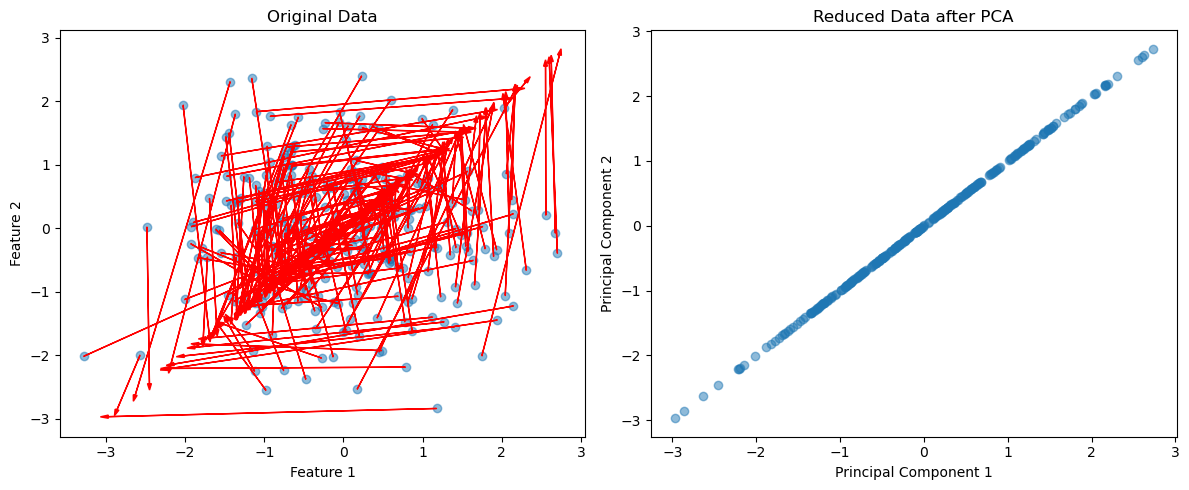

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_pca(X, X_reduced):
    """
    Visualize the original data and the data after applying PCA.

    Parameters:
    - X: torch.Tensor, shape (batch_size, n_samples, n_features)
      The original data tensor.
    - X_reduced: torch.Tensor, shape (batch_size, n_samples, n_components)
      The data transformed to the reduced-dimensional space.
    """
    batch_size, n_samples, n_features = X.size()
    n_components = X_reduced.size(2)

    # Reshape data for visualization
    X_reshaped = X.view(-1, n_features).numpy()
    X_reduced_reshaped = X_reduced.view(-1, n_components).numpy()

    # Create subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot original data
    axs[0].scatter(X_reshaped[:, 0], X_reshaped[:, 1], alpha=0.5)
    axs[0].set_title("Original Data")
    axs[0].set_xlabel("Feature 1")
    axs[0].set_ylabel("Feature 2")

    # Plot reduced data after PCA
    axs[1].scatter(X_reduced_reshaped[:, 0], X_reduced_reshaped[:, 0], alpha=0.5)
    axs[1].set_title("Reduced Data after PCA")
    axs[1].set_xlabel("Principal Component 1")
    axs[1].set_ylabel("Principal Component 2")

    # Add arrows to show movement
    for i in range(X_reshaped.shape[0]):
        axs[0].arrow(X_reshaped[i, 0], X_reshaped[i, 1],
                     X_reduced_reshaped[i, 0] - X_reshaped[i, 0],
                     X_reduced_reshaped[i, 0] - X_reshaped[i, 1],
                     head_width=0.05, head_length=0.1, fc='red', ec='red')

    plt.tight_layout()
    plt.show()

# Example usage:
batch_size = 3
n_samples = 100
n_features = 2  # Set to 3 for visualization
n_components = 1  # Set to 2 for visualization
X = torch.randn(batch_size, n_samples, n_features)
X_reduced = batch_pca(X, n_components)

# Visualize the data with arrows
visualize_pca(X, X_reduced)


In [ ]:
import numpy as np
import open3d as o3d
from sklearn.neighbors import NearestNeighbors

# Generate a random point cloud (replace with your actual point cloud)
point_cloud = np.random.rand(1000, 3)

# Set the number of neighbors for k-NN
k_neighbors = 10

# Find the nearest neighbors for each point
nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='kd_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

# Estimate normals using PCA on the local neighborhood
normals = []
for i in range(point_cloud.shape[0]):
    neighbor_points = point_cloud[indices[i]]
    centered_points = neighbor_points - neighbor_points.mean(axis=0)
    _, _, v = np.linalg.svd(centered_points.T)
    normals.append(v[2])  # Use the eigenvector corresponding to the smallest eigenvalue

normals = np.array(normals)

# Visualize the point cloud and normals using open3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.normals = o3d.utility.Vector3dVector(normals)
o3d.visualization.draw_geometries([pcd])


RuntimeError: 